In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.utils as utils

In [5]:
run_dir = '/data/estorrs/mushroom/data/projects/subclone'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT413C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclon

In [6]:
visium_config = {
    'dtype': 'visium',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'encoder_dim': 256,
        'kl_scaler': 0.,
        'recon_scaler': 1.,
        'neigh_scaler': 0.,
        'codebook_size': 100,
        'decoder_dims': (256, 1000, 5000,)
    },
    'learner_kwargs': {
        'scale': .1,
        'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 1,
        'device': 'cuda:2',
#         'channels': channels,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 10000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 500,
#         'save_dir': chkpt_dir       
    },
}

In [7]:
config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/testing/mushroom/{case}_vae_vq_visium/outputs')

config = yaml.safe_load(open(config_fp))

chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [8]:
config

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium.h5ad'},
   {'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.h5ad'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 55},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium.h5ad'},
   {'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.h5ad'}],
  'id': 's3',
  'position': 100},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorr

In [9]:
visium_config['sections'] = config
visium_config['train_kwargs']['save_dir'] = chkpt_dir

In [10]:
mushroom = Mushroom.from_config(visium_config)

INFO:root:using device: cuda:2
INFO:root:generating inputs for visium tissue sections
INFO:root:using 11622 channels
INFO:root:2 sections detected: ['s0', 's3']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized


In [11]:
b = next(iter(mushroom.learner.train_dl))

In [12]:
b.keys()

dict_keys(['anchor_idx', 'pos_idx', 'anchor_tile', 'pos_tile'])

In [13]:
for k, v in b.items(): print(k, v.shape)

anchor_idx torch.Size([64])
pos_idx torch.Size([64])
anchor_tile torch.Size([64, 11622, 8, 8])
pos_tile torch.Size([64, 11622, 8, 8])


In [14]:
b['anchor_idx'][:5], b['pos_idx'][:5]

(tensor([0, 0, 1, 0, 0]), tensor([1, 1, 0, 1, 1]))

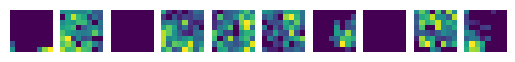

In [15]:
fig, axs = plt.subplots(ncols=10)
for i, ax in enumerate(axs):
    ax.imshow(b['anchor_tile'][i, mushroom.learner.channels.index('EPCAM')])
    ax.axis('off')

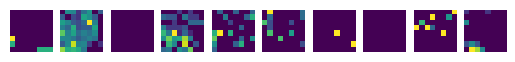

In [16]:
fig, axs = plt.subplots(ncols=10)
for i, ax in enumerate(axs):
    ax.imshow(b['pos_tile'][i, mushroom.learner.channels.index('EPCAM')])
    ax.axis('off')

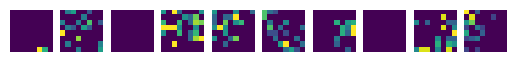

In [17]:
fig, axs = plt.subplots(ncols=10)
for i, ax in enumerate(axs):
    ax.imshow(b['anchor_tile'][i, mushroom.learner.channels.index('PTPRC')])
    ax.axis('off')

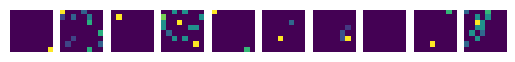

In [18]:
fig, axs = plt.subplots(ncols=10)
for i, ax in enumerate(axs):
    ax.imshow(b['pos_tile'][i, mushroom.learner.channels.index('PTPRC')])
    ax.axis('off')

In [19]:
with torch.no_grad():
    device = mushroom.learner.device
    anchor_x, anchor_slide = b['anchor_tile'], b['anchor_idx']
    pos_x, pos_slide = b['pos_tile'], b['pos_idx']
    x = torch.concat((anchor_x, pos_x))
    slide = torch.concat((anchor_slide, pos_slide))
    x, slide = x.to(device), slide.to(device)

    losses, outputs = mushroom.learner.sae(x, slide)

In [20]:
for k, v in losses.items(): print(k, v)

overall_loss tensor(0.5996, device='cuda:2')
recon_loss tensor(0.5996, device='cuda:2')
kl_loss tensor(68.1520, device='cuda:2')
neigh_loss tensor(4.6042, device='cuda:2')


In [21]:
for k, v in outputs.items(): print(k, v.shape)

encoded_tokens_prequant torch.Size([128, 65, 256])
encoded_tokens torch.Size([128, 65, 256])
pred_pixel_values torch.Size([128, 64, 11622])
clusters torch.Size([128, 64])


In [22]:
mushroom.train()

INFO:root:iteration 0: {'overall_loss': tensor(0.5674, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5674, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(68.0779, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.6032, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/projects/testing/mushroom/HT397B1_vae_vq_visium/outputs/chkpts/0iter.pt
INFO:root:iteration 10: {'overall_loss': tensor(0.5682, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5682, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(109.2403, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.5142, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 20: {'overall_loss': tensor(0.3982, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3982, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(134.5188, device='cuda:2', grad_fn=<MeanBa

INFO:root:iteration 260: {'overall_loss': tensor(0.2665, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2665, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(384.4238, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.2174, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 270: {'overall_loss': tensor(0.3373, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3373, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(372.8364, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.2095, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 280: {'overall_loss': tensor(0.3059, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3059, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(393.4060, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.2005, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 290: {'overall_loss'

INFO:root:iteration 520: {'overall_loss': tensor(0.2703, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2703, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(417.0319, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0915, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 530: {'overall_loss': tensor(0.2842, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2842, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(438.5768, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1999, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 540: {'overall_loss': tensor(0.2469, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2469, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(418.7307, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0825, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 550: {'overall_loss'

INFO:root:iteration 780: {'overall_loss': tensor(0.2661, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2661, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(486.9682, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1272, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 790: {'overall_loss': tensor(0.2769, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2769, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(501.2509, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1129, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 800: {'overall_loss': tensor(0.3061, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3061, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(505.4813, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.2041, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 810: {'overall_loss'

INFO:root:iteration 1040: {'overall_loss': tensor(0.2649, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2649, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(521.3855, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1862, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1050: {'overall_loss': tensor(0.2661, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2661, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(522.4188, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.2198, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1060: {'overall_loss': tensor(0.2609, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2609, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(515.8971, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1665, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1070: {'overall_l

INFO:root:iteration 1300: {'overall_loss': tensor(0.2684, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2684, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(581.5585, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1700, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1310: {'overall_loss': tensor(0.2443, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2443, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(581.6100, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.2458, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1320: {'overall_loss': tensor(0.2556, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2556, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(593.2100, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1485, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1330: {'overall_l

INFO:root:iteration 1560: {'overall_loss': tensor(0.2559, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2559, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(616.8476, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1723, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1570: {'overall_loss': tensor(0.3167, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3167, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(669.2436, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.2139, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1580: {'overall_loss': tensor(0.2876, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2876, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(637.8752, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.2239, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1590: {'overall_l

INFO:root:iteration 1820: {'overall_loss': tensor(0.2618, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2618, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(695.5594, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.2898, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1830: {'overall_loss': tensor(0.2820, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2820, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(713.5413, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1502, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1840: {'overall_loss': tensor(0.2372, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2372, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(693.9424, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.2185, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1850: {'overall_l

INFO:root:iteration 2080: {'overall_loss': tensor(0.2812, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2812, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(749.7436, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1512, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2090: {'overall_loss': tensor(0.2480, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2480, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(733.0705, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1864, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2100: {'overall_loss': tensor(0.2335, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2335, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(700.0517, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0925, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2110: {'overall_l

INFO:root:iteration 2340: {'overall_loss': tensor(0.2474, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2474, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(768.8271, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1315, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2350: {'overall_loss': tensor(0.2345, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2345, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(765.3552, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0658, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2360: {'overall_loss': tensor(0.2521, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2521, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(780.5195, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1068, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2370: {'overall_l

INFO:root:iteration 2600: {'overall_loss': tensor(0.2649, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2649, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(858.8282, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1569, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2610: {'overall_loss': tensor(0.2764, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2764, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(824.3908, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.3079, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2620: {'overall_loss': tensor(0.2536, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2536, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(845.5695, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1611, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2630: {'overall_l

INFO:root:iteration 2860: {'overall_loss': tensor(0.2806, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2806, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(954.5886, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.2276, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2870: {'overall_loss': tensor(0.2589, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2589, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(952.0441, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1098, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2880: {'overall_loss': tensor(0.2791, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2791, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(926.7494, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0887, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2890: {'overall_l

INFO:root:iteration 3120: {'overall_loss': tensor(0.3014, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3014, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(954.4208, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1867, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3130: {'overall_loss': tensor(0.2321, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2321, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(905.0450, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1370, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3140: {'overall_loss': tensor(0.2515, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2515, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(940.2948, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0998, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3150: {'overall_l

INFO:root:iteration 3420: {'overall_loss': tensor(0.2375, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2375, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(958.7125, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0262, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3430: {'overall_loss': tensor(0.2887, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2887, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(967.3786, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1921, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3440: {'overall_loss': tensor(0.2935, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2935, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(965.4410, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1536, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3450: {'overall_l

INFO:root:iteration 3680: {'overall_loss': tensor(0.2615, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2615, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(971.6119, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1770, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3690: {'overall_loss': tensor(0.2497, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2497, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(958.9249, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0428, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3700: {'overall_loss': tensor(0.2570, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2570, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(964.6251, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1416, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3710: {'overall_l

INFO:root:iteration 3940: {'overall_loss': tensor(0.2656, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2656, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(951.4967, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1437, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3950: {'overall_loss': tensor(0.2405, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2405, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(932.0417, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1361, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3960: {'overall_loss': tensor(0.3056, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3056, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(967.7104, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1719, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3970: {'overall_l

INFO:root:iteration 4200: {'overall_loss': tensor(0.2917, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2917, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1053.9062, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1385, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4210: {'overall_loss': tensor(0.1983, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1983, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1016.9692, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0356, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4220: {'overall_loss': tensor(0.2065, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2065, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1014.9557, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0144, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4230: {'overal

INFO:root:iteration 4460: {'overall_loss': tensor(0.2471, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2471, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(983.3110, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0700, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4470: {'overall_loss': tensor(0.2494, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2494, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(982.3221, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1609, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4480: {'overall_loss': tensor(0.2857, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2857, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1018.6987, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.3240, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4490: {'overall_

INFO:root:iteration 4720: {'overall_loss': tensor(0.2704, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2704, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1023.3089, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1514, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4730: {'overall_loss': tensor(0.2195, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2195, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(993.2498, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0108, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4740: {'overall_loss': tensor(0.2376, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2376, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(997.8542, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0841, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4750: {'overall_

INFO:root:iteration 4980: {'overall_loss': tensor(0.2435, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2435, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(950.3403, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1066, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4990: {'overall_loss': tensor(0.2955, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2955, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(978.0220, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1074, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 5000: {'overall_loss': tensor(0.2634, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2634, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(948.9207, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1444, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:saving checkpoint to /data/

INFO:root:iteration 5240: {'overall_loss': tensor(0.3091, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3091, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1051.5432, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0771, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 5250: {'overall_loss': tensor(0.2371, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2371, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1015.8463, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0154, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 5260: {'overall_loss': tensor(0.2884, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2884, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1053.9825, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0961, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 5270: {'overal

INFO:root:iteration 5500: {'overall_loss': tensor(0.3039, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3039, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1112.3182, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0063, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/projects/testing/mushroom/HT397B1_vae_vq_visium/outputs/chkpts/5500iter.pt
INFO:root:iteration 5510: {'overall_loss': tensor(0.2580, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2580, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1114.1816, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0249, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 5520: {'overall_loss': tensor(0.2782, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2782, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1114.7197, device='cuda:2', g

INFO:root:iteration 5760: {'overall_loss': tensor(0.2770, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2770, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1121.4851, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1287, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 5770: {'overall_loss': tensor(0.3049, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3049, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1124.5653, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0684, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 5780: {'overall_loss': tensor(0.2806, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2806, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1124.5834, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0912, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 5790: {'overal

INFO:root:iteration 6020: {'overall_loss': tensor(0.3084, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3084, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1154.0503, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0622, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 6030: {'overall_loss': tensor(0.3195, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3195, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1146.5737, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1339, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 6040: {'overall_loss': tensor(0.2865, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2865, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1159.2484, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0078, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 6050: {'overal

INFO:root:iteration 6280: {'overall_loss': tensor(0.2792, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2792, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1178.6434, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9766, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 6290: {'overall_loss': tensor(0.2951, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2951, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1177.3684, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0820, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 6300: {'overall_loss': tensor(0.2857, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2857, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1208.9214, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0275, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 6310: {'overal

INFO:root:iteration 6540: {'overall_loss': tensor(0.3164, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3164, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1187.6769, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.1692, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 6550: {'overall_loss': tensor(0.3042, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3042, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1207.1224, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9673, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 6560: {'overall_loss': tensor(0.2550, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2550, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1158.2217, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9857, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 6570: {'overal

INFO:root:iteration 6800: {'overall_loss': tensor(0.2797, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2797, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1185.1017, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0638, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 6810: {'overall_loss': tensor(0.2185, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2185, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1171.3076, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9600, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 6820: {'overall_loss': tensor(0.2577, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2577, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1196.6689, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9298, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 6830: {'overal

INFO:root:iteration 7060: {'overall_loss': tensor(0.3276, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3276, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1232.4733, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0849, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 7070: {'overall_loss': tensor(0.2730, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2730, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1211.0082, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0295, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 7080: {'overall_loss': tensor(0.3085, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3085, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1234.8370, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0544, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 7090: {'overal

INFO:root:iteration 7320: {'overall_loss': tensor(0.2687, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2687, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1210.5885, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0319, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 7330: {'overall_loss': tensor(0.2439, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2439, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1194.2715, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0146, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 7340: {'overall_loss': tensor(0.2940, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2940, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1220.1941, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9476, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 7350: {'overal

INFO:root:iteration 7580: {'overall_loss': tensor(0.2663, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2663, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1226.3324, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0300, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 7590: {'overall_loss': tensor(0.3134, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3134, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1248.3829, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0039, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 7600: {'overall_loss': tensor(0.2991, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2991, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1261.3252, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0236, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 7610: {'overal

INFO:root:iteration 7840: {'overall_loss': tensor(0.2367, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2367, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1228.5166, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0120, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 7850: {'overall_loss': tensor(0.3009, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3009, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1234.3418, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9968, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 7860: {'overall_loss': tensor(0.2416, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2416, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1208.2581, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9229, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 7870: {'overal

INFO:root:iteration 8100: {'overall_loss': tensor(0.2954, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2954, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1262.2303, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9909, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 8110: {'overall_loss': tensor(0.2776, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2776, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1245.8552, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0012, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 8120: {'overall_loss': tensor(0.3020, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3020, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1254.9049, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0088, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 8130: {'overal

INFO:root:iteration 8360: {'overall_loss': tensor(0.2406, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2406, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1232.5697, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9695, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 8370: {'overall_loss': tensor(0.2682, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2682, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1227.9050, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0090, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 8380: {'overall_loss': tensor(0.3401, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3401, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1293.5392, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0925, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 8390: {'overal

INFO:root:iteration 8620: {'overall_loss': tensor(0.2566, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2566, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1231.8508, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9478, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 8630: {'overall_loss': tensor(0.2993, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2993, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1275.9005, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9882, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 8640: {'overall_loss': tensor(0.2202, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2202, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1237.7101, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9746, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 8650: {'overal

INFO:root:iteration 8880: {'overall_loss': tensor(0.2656, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2656, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1244.6648, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9301, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 8890: {'overall_loss': tensor(0.2582, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2582, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1281.1926, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0145, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 8900: {'overall_loss': tensor(0.2176, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2176, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1274.0887, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9398, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 8910: {'overal

INFO:root:iteration 9140: {'overall_loss': tensor(0.2843, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2843, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1302.1512, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9587, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 9150: {'overall_loss': tensor(0.3470, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3470, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1328.5476, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9636, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 9160: {'overall_loss': tensor(0.2483, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2483, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1277.5835, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.8557, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 9170: {'overal

INFO:root:iteration 9400: {'overall_loss': tensor(0.2758, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2758, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1315.4728, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9796, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 9410: {'overall_loss': tensor(0.2820, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2820, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1279.8354, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9866, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 9420: {'overall_loss': tensor(0.2667, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2667, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1280.8494, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0055, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 9430: {'overal

INFO:root:iteration 9660: {'overall_loss': tensor(0.2682, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2682, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1293.9479, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0108, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 9670: {'overall_loss': tensor(0.2434, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2434, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1271.7748, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9076, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 9680: {'overall_loss': tensor(0.3186, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3186, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1332.2228, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0237, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 9690: {'overal

INFO:root:iteration 9920: {'overall_loss': tensor(0.2790, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2790, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1288.7939, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.9969, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 9930: {'overall_loss': tensor(0.2569, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2569, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1262.3192, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.8737, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 9940: {'overall_loss': tensor(0.2920, device='cuda:2', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2920, device='cuda:2', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(1288.8402, device='cuda:2', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(4.0246, device='cuda:2', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 9950: {'overal